In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8")

In [42]:
def load_csv(path):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip().str.lower()
    
    # 1. CLEANING STEP: Remove commas and convert to numbers
    if 'close' in df.columns:
        # Remove commas if they exist
        df['close'] = df['close'].astype(str).str.replace(',', '')
        # Convert to float, turning errors into 'NaN' (Not a Number)
        df['close'] = pd.to_numeric(df['close'], errors='coerce')
    
    # (Keep your existing date logic below)
    df['date'] = pd.to_datetime(df['date'], format='mixed', dayfirst=True)
    df.set_index('date', inplace=True)
    return df.sort_index().dropna(subset=['close']) # Drop rows where close is missing

nifty = load_csv("data/nifty50.csv")
banknifty = load_csv("data/banknifty.csv")

stocks = {
    "reliance": load_csv("data/reliance.csv"),
    "tcs": load_csv("data/tcs.csv"),
    "hdfcbank": load_csv("data/hdfcbank.csv"),
    "infy": load_csv("data/infy.csv"),
    "icicibank": load_csv("data/icicibank.csv")
}


In [43]:
# 1. Find the dates that exist in EVERY dataset
common_index = nifty.index.intersection(banknifty.index)

for k in stocks:
    common_index = common_index.intersection(stocks[k].index)

# 2. Now filter everything using that shared index
nifty = nifty.loc[common_index]
banknifty = banknifty.loc[common_index]

for k in stocks:
    stocks[k] = stocks[k].loc[common_index]

print(f"Alignment complete. Data covers {len(common_index)} common days.")

Alignment complete. Data covers 1737 common days.


In [44]:
nifty_features = pd.DataFrame(index=nifty.index)

nifty_features["nifty_return"] = nifty["close"].pct_change()
nifty_features["nifty_volatility"] = nifty_features["nifty_return"].rolling(10).std()

bank_features = pd.DataFrame(index=banknifty.index)
bank_features["banknifty_return"] = banknifty["close"].pct_change()


In [45]:
def create_stock_features(df):
    features = pd.DataFrame(index=df.index)

    # Returns
    features["return"] = df["close"].pct_change()

    # Moving averages
    features["sma_20"] = ta.trend.SMAIndicator(df["close"], 20).sma_indicator()
    features["sma_50"] = ta.trend.SMAIndicator(df["close"], 50).sma_indicator()

    # Momentum
    features["rsi"] = ta.momentum.RSIIndicator(df["close"], 14).rsi()

    # Volatility
    features["volatility"] = features["return"].rolling(10).std()

    return features


In [46]:
stock_name = "hdfcbank"
df_stock = stocks[stock_name]

X_stock = create_stock_features(df_stock)

# Merge market context
X = pd.concat([X_stock, nifty_features, bank_features], axis=1)

# Target: next-day direction
y = (df_stock["close"].shift(-1) > df_stock["close"]).astype(int)

# Final dataset
dataset = pd.concat([X, y.rename("target")], axis=1).dropna()
dataset.head()


,return,sma_20,sma_50,rsi,volatility,nifty_return,nifty_volatility,banknifty_return,target
date,,,,,,,,,
2019-03-12,0.019991,2111.4175,2111.140,64.388707,0.009300,0.011922,0.006495,0.017058,1
2019-03-13,0.025587,2116.2600,2112.709,72.219350,0.011247,0.003584,0.005876,0.015490,0
2019-03-14,-0.000808,2120.3250,2114.634,71.669409,0.010387,0.000137,0.005552,0.001343,1
2019-03-15,0.012698,2127.4650,2117.458,74.899904,0.009423,0.007370,0.005141,0.015847,1
2019-03-18,0.003751,2135.5050,2120.338,75.789198,0.009367,0.003094,0.005196,0.007306,1


In [47]:
dataset["target"].value_counts(normalize=True)

target
1    0.517773
0    0.482227
Name: proportion, dtype: float64

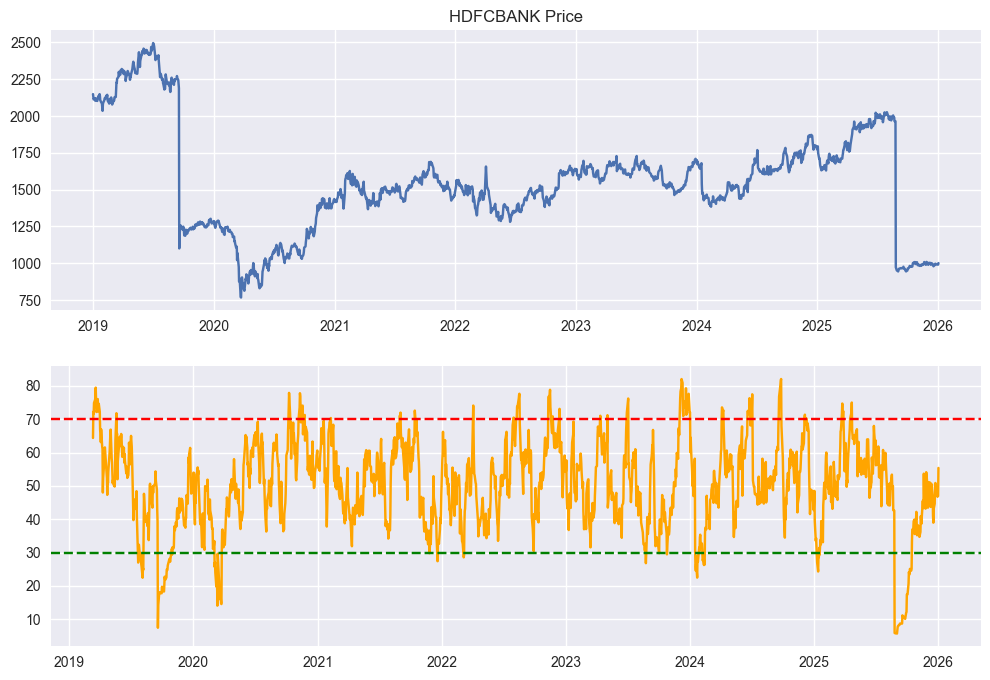

In [48]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(df_stock["close"], label="Close Price")
ax[0].set_title(f"{stock_name.upper()} Price")

ax[1].plot(dataset["rsi"], label="RSI", color="orange")
ax[1].axhline(70, color="red", linestyle="--")
ax[1].axhline(30, color="green", linestyle="--")

plt.show()


In [49]:
dataset.to_csv(f"data/{stock_name}_ml_dataset.csv")

In [50]:
print(dataset.shape)
dataset["target"].value_counts(normalize=True)


(1688, 9)


target
1    0.517773
0    0.482227
Name: proportion, dtype: float64